In [1]:
using Pkg, Logging
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras"));

In [2]:
Pkg.instantiate()
with_logger(NullLogger()) do
    pkg"precompile"
end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [3]:
using MINLPTrajOpt
using MeshCatMechanisms
using RigidBodyDynamics
using LinearAlgebra
using RigidBodyDynamics: Bounds, lower, upper

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [4]:
urdf = joinpath(dirname(pathof(MINLPTrajOpt)), "..", "urdf", "Pendulum.urdf")
mechanism = parse_urdf(urdf, revolute_joint_type=SinCosRevolute{Float64})
joint = first(joints(mechanism))
l = norm(center_of_mass(spatial_inertia(successor(joint, mechanism))).v)
m = mass(mechanism)
g = norm(mechanism.gravitational_acceleration)
τmax = 0.9 * m * g * l
effort_bounds(joint) .= Bounds(-τmax, τmax);

In [5]:
@time mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
with_logger(NullLogger()) do
    open(mvis)
end

 15.770467 seconds (47.61 M allocations: 2.285 GiB, 9.62% gc time)


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

In [6]:
using JuMP
using BARON
using CouenneNL

In [7]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = false;

In [8]:
N = 60
objective = MinEffort()
T = objective isa MinEffort ? 4.5 : nothing
fixedstep = objective isa MinEffort

if fixedstep
    Δt = T / N
    Δtmin = Δt
    Δtmax = Δt
else
    Δtmin = 1e-3
    Δtmax = 0.5
end
Δθmax = 0.6#vmax * Δtmin

x0 = MechanismState(mechanism)
θ0 = 0.1
θd0 = 0.0
set_configuration!(x0, joint, θ0)
set_velocity!(x0, joint, θd0)

xf = MechanismState(mechanism)
set_configuration!(xf, joint, π)
zero_velocity!(xf)

solver = BaronSolver(threads=Sys.CPU_THREADS, MaxTime=10 * 60.0, PrTimeFreq=5.)
problem = TrajOptProblem(mechanism, x0, solver;
    xf=xf, Δtmin=Δtmin, Δtmax=Δtmax, T=T, N=N, Δθmax=Δθmax, objective=objective);

In [9]:
copyto!(mvis, x0)

In [10]:
status = solve(problem.model)
@assert status == :Optimal

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  2.14276977360     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s) 

In [11]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "pendulum", "run$i"); isdir(datadir))
        global i
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(problem.model.internalModel.options[:SumName], joinpath(datadir, "sum.lst"))
end

"/home/twan/code/julia-projects/MINLPTrajOpt/src/../data/pendulum/run0/sum.lst"

In [12]:
using PlottingTools
using PlottingTools.LaTeXStrings
using PlottingTools.PGFPlotsX
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

PDFLATEX::LaTeXEngine = 1

In [13]:
ts = [0.0; cumsum(getvalue.(problem.Δts))]
qs = [Vector(configuration(x0)), getvalue.(problem.qs)...]
Δθs = atan.(getvalue.(first.(problem.Δqs)) ./ getvalue.(last.(problem.Δqs)))
θs = θ0 .+ [0.0; cumsum(Δθs)]
τs = getvalue.(first.(problem.τs));

In [14]:
setanimation!(mvis, ts, qs)

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #setanimation!#4(::Int64, ::Bool, ::Int64, ::Function, ::MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,SinCosRevolute{Float64}},1}},1}},MeshCat.Visualizer}, ::Array{Float64,1}, ::Array{Array{Float64,1},1}) at animate.jl:46
└ @ MeshCatMechanisms /home/twan/.julia/packages/MeshCatMechanisms/AHOtT/src/animate.jl:46


In [15]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "θ0 = $θ0")
        println(io, "θd0 = $θd0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

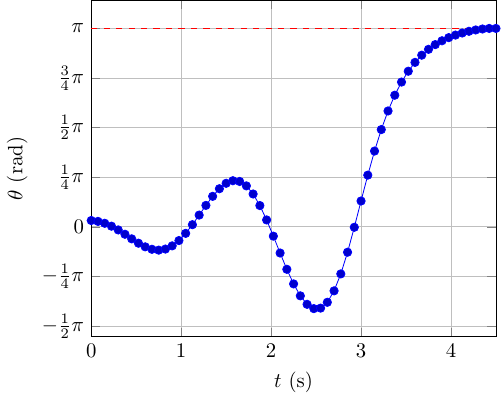

In [16]:
p = timeplot(ts, θs; ylabel=L"$\theta$ (rad)")
push!(p, @pgf HLine({dashed, red, thick}, Float64(π)))
piticks!(p, 1//4, θs; axis=:y)
save_data && pgfsave(joinpath(datadir, "theta.pdf"), p)
p

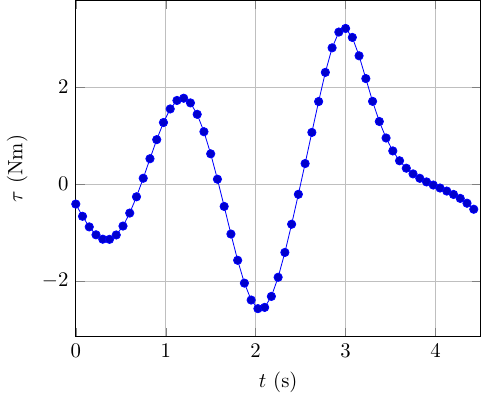

In [17]:
p = timeplot(ts[1 : end - 1], τs; ylabel=L"$\tau$ (Nm)", tmax=ts[end])
push!(p, @pgf HLine({dashed, red, thick}, τmax))
push!(p, @pgf HLine({dashed, red, thick}, -τmax))
save_data && pgfsave(joinpath(datadir, "tau.pdf"), p)
p